In [1]:
#link google drive

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

#install any necessary packages to the colab env
!pip install wfdb
!pip install neurokit2
!pip install py-ecg-detectors
!pip install bigO

#from each package import relevant functions
import os
os.getcwd()
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/Orphanidou "
os.chdir(new_direct)
from orphanidou import assess_qual

path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/Automated_ecg_assessment_og'
os.chdir(path)
from toolbox.AlgorithmsV5_k_model import processing

import os
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/ECGAssess_og'
os.chdir(path)
from Code.AlgorithmsV5 import processing1

import os
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_project/framework_for_synthetic_biosignals"
os.chdir(new_direct)
# %matplotlib widget

import ecg_generator as eg
import noise_generator as ng
import beat_interval_generator as big
import tensorflow as tf

import sys
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project'
os.chdir(path)

from functions import plotting_df
from functions import first_below_05

#other tools to use
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from ecgdetectors import Detectors
import scipy.stats
import neurokit2 as nk
import time
import tensorflow as tf
import pandas as pd


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=b5e6e31438adca379fdcb5725082b872d6a2fac67f9789310612a435e86e9dfd
  Stored in directory: /root/.cache/pip/wheels/13/39/c2/d113611d276bf55252ed5a640e98596d7dcc96535afbf254d5
Successfully built gatspy


In [ ]:
#load in the pre-set beat intervals control HR
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_work/framework_for_synthetic_biosignals/beats_array.npy'
beats2 = np.load(path)

In [ ]:
#Changing the white noise:
#set the increment in white
increment = 2

# Create a dataframe with the following columns: noise type, signal, SQA1, SQA2, SQA3
df_WN = pd.DataFrame(columns=['Noise Type', 'SQA1', 'SQA2', 'SQA3', 'SQA4'])


# Generate and plot ECG signals with increasing heart rates
for i in range(0, 100):

    # Calculate heart rate for the current signal
    wn = 0 + i * increment  # Incremental increase from 20 to 200 BPM
    print(wn)

    #create preset zero's array for efficiency
    SQA_O = np.zeros(100)
    SQA_Z = np.zeros(100)
    SQA_E = np.zeros(100)
    SQA_A = np.zeros(100)


    #add heart rate to the dataframe
    df_WN.at[i, 'Noise Type'] = str(wn)

    #create 100 variations with the same set variable
    for j in range(100):

      # Create ECG signal with the specified WN
      ecg = eg.ECGGenerator()
      ecg.beat_interval_generator.beat_intervals = beats2
      ecg.noise_generator.noise_type.wn = wn
      signal, peaks, labels, beats = ecg.generate()
      signal = signal[0:2000]

      #plt.plot(signal)
      #plt.show()

      #run the signal through Orphanidou SQI
      quality_o = assess_qual(signal, fs = 200, thresh = 0.66)

      #run the signal through the Zhao & Zhang SQI with a break if failure
      try:
        quality_z = nk.ecg_quality(signal, sampling_rate=200, method="zhao2018")
      except Exception as e:
        print(f"An error occurred: {e}")
        quality_z = 'Unacceptable'

      #resample the signal (to 500Hz) and reshape into an array with the first row as the index for values in ECG (for final 2 SQI's)
      resampled_signal = nk.signal_resample(signal, sampling_rate=200, desired_sampling_rate=500, method="numpy")
      reshaped_array = np.vstack((np.arange(5000), resampled_signal))

      #run the processed signal through the ECGAssess (processsing1 func)
      quality_e = processing1(reshaped_array, total_leads=1, temp_freq=500)

      #run the prcoessed signal through the Elegendi SQI (processing func)
      qaulity_a = processing(reshaped_array, num_leads=1, temp_freq = 500, SNR_threshold = 0.5, signal_freq_band = [2, 40], window_length = 100, heart_rate_limits = [25, 300], max_loss_passband = 0.1,
               min_loss_stopband=20, sampling_frequency=500, path_model='/content/drive/MyDrive/Colab_Notebooks/CiC_work/Automated_ecg_assessment_og/cnn_lstm/', name_model = 'saved_model')

      #add the results of the orphanidou & Zhao Zhang SQI to the saved arrays
      SQA_O[j] = 0 if quality_o == 0 else 1
      SQA_Z[j] = 0 if quality_z == 'Unacceptable' else 1

      #for ECGAssess and Elgendi SQI's then need to extract outputs from the SQI ('✖' = fail)
      ecg_result = 0 if quality_e[3][0] == '✖' else 1
      SQA_E[j] = 0 if ecg_result == 0 else 1

      auto_result = 0 if qaulity_a[4][0] == '✖' else 1
      SQA_A[j] = 0 if auto_result == 0 else 1


    #calculate the mean chance of pass value from each iteration of 50 signals and add to dataframe
    SQA_O_prob = np.mean(SQA_O)
    print(SQA_O_prob)
    df_WN.at[i, 'SQA1'] = SQA_O_prob

    SQA_Z_prob = np.mean(SQA_Z)
    print(SQA_Z_prob)
    df_WN.at[i, 'SQA2'] = SQA_Z_prob

    SQA_E_prob = np.mean(SQA_E)
    print(SQA_E_prob)
    df_WN.at[i, 'SQA3'] = SQA_E_prob

    SQA_A_prob = np.mean(SQA_A)
    print(SQA_A_prob)
    df_WN.at[i, 'SQA4'] = SQA_A_prob

path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)
df_WN.to_csv('WN_final')


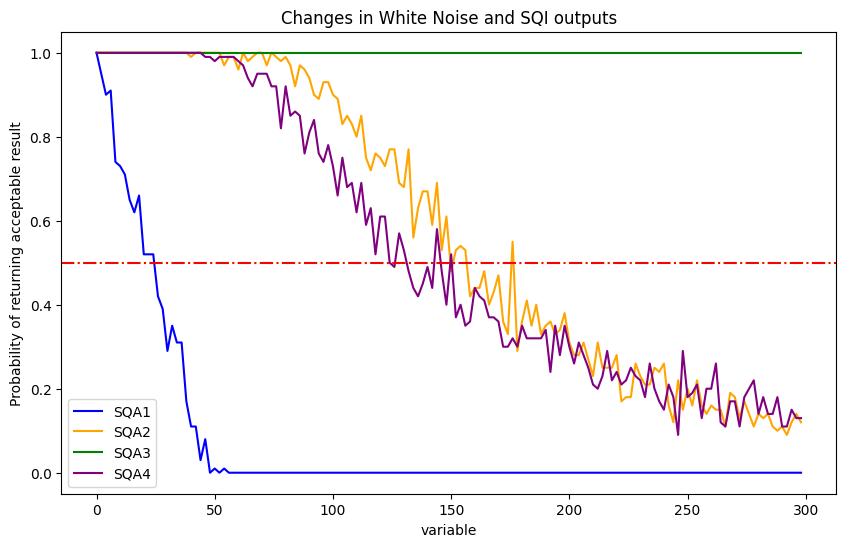

In [ ]:
#if cells above already run can then import the dataframe from saved_data file
path = '/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data'
os.chdir(path)

dfWN = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CiC_project/saved_data/WN_final')
plotting_df(dfWN, 'Changes in White Noise and SQI outputs')

In [ ]:
dfWN[50:100]

,Unnamed: 0.2,Unnamed: 0,Noise Type,SQA1,SQA2,SQA3,SQA4,Unnamed: 0.1
50,50,50.0,100,0.0,0.90,1.0,0.73,0.0
51,51,51.0,102,0.0,0.89,1.0,0.66,1.0
52,52,52.0,104,0.0,0.83,1.0,0.75,2.0
53,53,53.0,106,0.0,0.85,1.0,0.68,3.0
54,54,54.0,108,0.0,0.83,1.0,0.69,4.0
55,55,55.0,110,0.0,0.80,1.0,0.62,5.0
56,56,56.0,112,0.0,0.85,1.0,0.69,6.0
57,57,57.0,114,0.0,0.75,1.0,0.59,7.0
58,58,58.0,116,0.0,0.72,1.0,0.63,8.0
59,59,59.0,118,0.0,0.76,1.0,0.52,9.0


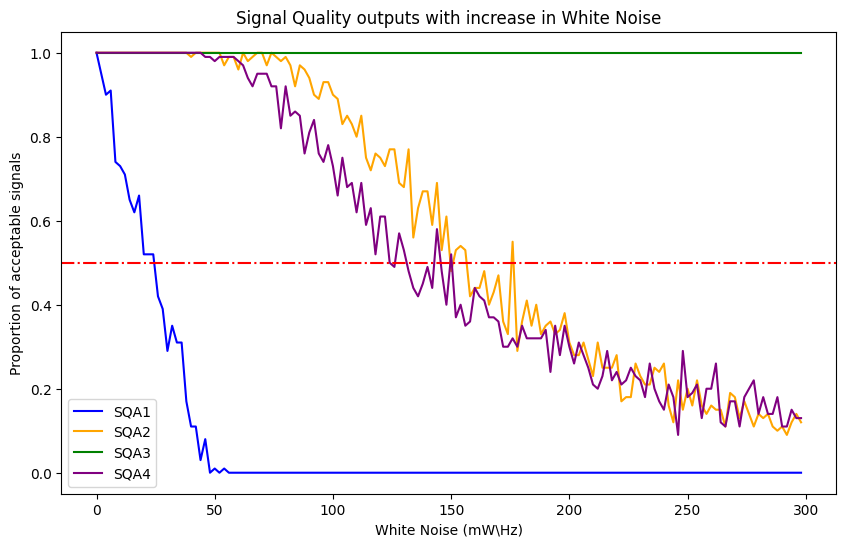

In [ ]:
def plotting_df1(df, variable):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Noise Type'], df['SQA1'], color='blue', label='SQA1')
    plt.plot(df['Noise Type'], df['SQA2'], color='orange', label='SQA2')
    plt.plot(df['Noise Type'], df['SQA3'], color='green', label='SQA3')
    plt.plot(df['Noise Type'], df['SQA4'], color='purple', label='SQA4')

    # Dotted line at 0.5 for probability
    plt.axhline(y=0.5, color='red', linestyle='-.')

    # Add labels and title
    plt.xlabel('White Noise (mW\Hz)')
    plt.ylabel('Proportion of acceptable signals')
    plt.title(variable)
    plt.legend()

    # Display the plot
    plt.show()

plotting_df1(dfWN, 'Signal Quality outputs with increase in White Noise')


In [ ]:
#use the function first_below_05 to find the first value from each SQI that returned a value below 0.5

SQI1 = first_below_05(dfWN, 'SQA1')
print(SQI1)
SQI2 = first_below_05(dfWN, 'SQA2')
print(SQI2)
SQI3 = first_below_05(dfWN, 'SQA3')
print(SQI3)
SQI4 = first_below_05(dfWN, 'SQA4')
print(SQI4)

26
150
None
126


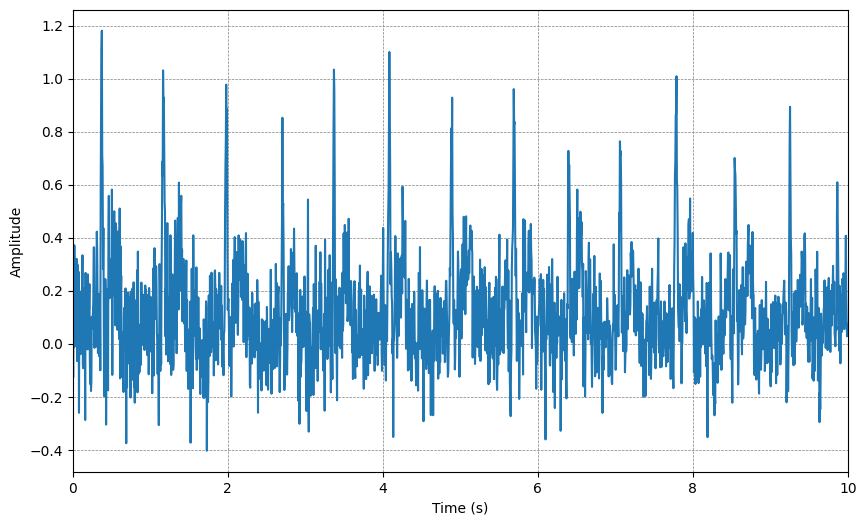

In [ ]:
#produce the graphs for at the maximum HR at at which point the SQI's still return a pass value:


ecg = eg.ECGGenerator()
ecg.beat_interval_generator.beat_intervals = beats2
ecg.noise_generator.noise_type.wn = SQI1-2
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 10)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 11, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

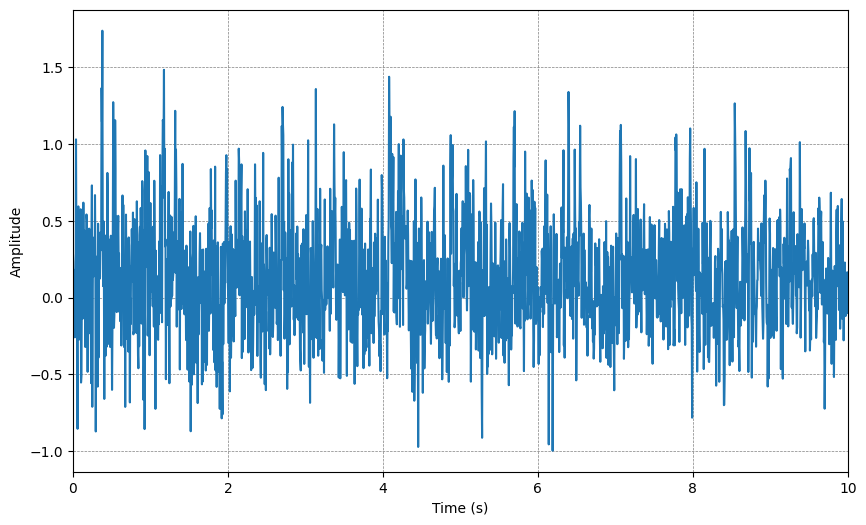

In [ ]:

ecg = eg.ECGGenerator()
ecg.beat_interval_generator.beat_intervals = beats2
ecg.noise_generator.noise_type.wn = SQI2-2
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 10)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 11, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

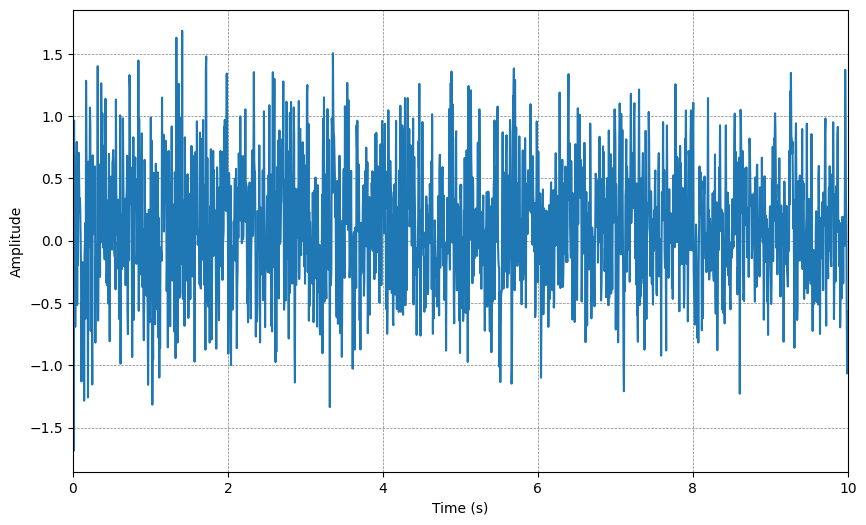

In [ ]:
#no point at white value increase for which SQI3 returns a label of unacceptable so set it to the maximum run in the testing (300)
ecg = eg.ECGGenerator()
ecg.beat_interval_generator.beat_intervals = beats2
ecg.noise_generator.noise_type.wn = 300
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 10)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 11, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

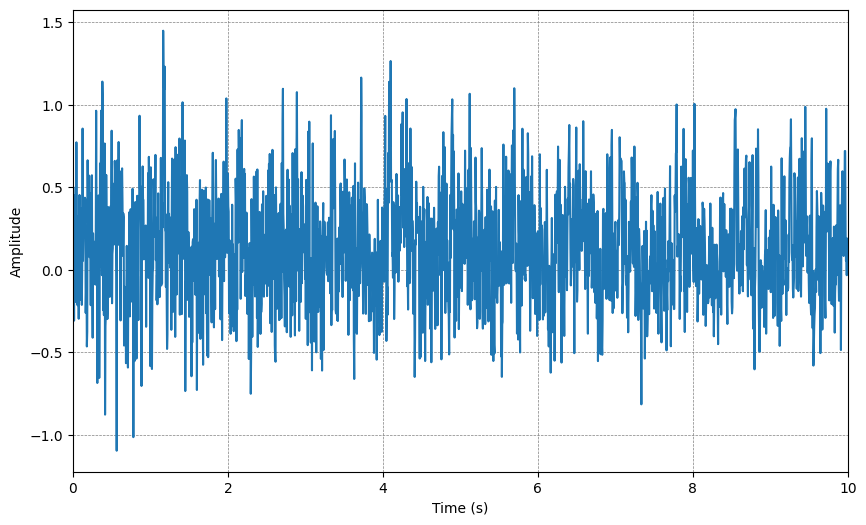

In [ ]:

ecg = eg.ECGGenerator()
ecg.beat_interval_generator.beat_intervals = beats2
ecg.noise_generator.noise_type.wn = SQI4-2
signal, peaks, labels, beats2 = ecg.generate()
signal = signal[0:2000]

sampling_rate = 200
time = np.arange(len(signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, signal)
plt.grid(True, which='both', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 10)

# Set the x-axis tick intervals to 2
plt.xticks(np.arange(0, 11, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()